## Using Lasagne for Data Classification

In [31]:
from __future__ import print_function

import sys
import os
import time

import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

import lasagne
import sklearn.datasets

%matplotlib inline

In [32]:
n_samples = 100
noise = 0.1

Create some test data using sklearn's moon data set

In [33]:
np.random.seed(0)
X, y = sklearn.datasets.make_moons(n_samples=n_samples, noise=noise)
#  Now we have to conver the data into theano floats
X = X.astype(theano.config.floatX)  #  data
y = y.astype('int32')  #  labels two types

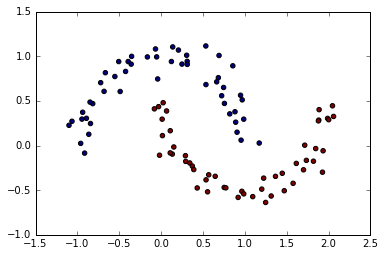

In [34]:
plt.scatter(X[:, 0], X[:, 1], c=y)  # scatter plot of the data with the color as the label

## Here is where we start to build our network

In [35]:
input_var = T.matrix('inputs')  # Is this thre correct type? 
target_var = T.ivector('targets')  # This should have the same type as y?

We define a network with one hidden layer [l_hidden].
The algebra of the network is
\begin{align}
z_1 &=& {\bf W}_1* x + b_1\\
z_2 &=& {\bf W}_2 * \tanh(z_1) + b_2\\
y_{\text{pred}} &=& softmax(z_2)
\end{align}

In [47]:
l_in = lasagne.layers.InputLayer(shape=(None, 2), input_var=None)
# We'll create a network with two dense layers: A tanh hidden layer and a softmax output layer.
l_hidden = lasagne.layers.DenseLayer(# The first argument is the input layer
                l_in,
                # This defines the layer's output dimensionality
                num_units=10,
                # Various nonlinearities are available
                nonlinearity=lasagne.nonlinearities.tanh,
                # intialize the weigths
                W=lasagne.init.GlorotUniform())
# For our output layer, we'll use a dense layer with a softmax nonlinearity.
l_output = lasagne.layers.DenseLayer(l_hidden, num_units=2, nonlinearity=lasagne.nonlinearities.softmax)

In [48]:
prediction = lasagne.layers.get_output(l_output) #  prediction of network y_pred

## Now we define the training functions 

Catogorical Cross entropy is defined as 
\begin{equation}
S_i = -\sum_j t_{ij} \log(p_{ij})
\end{equation}
we will take the average cross entropy as our loss function
\begin{equation}
L = \langle S_i\rangle_i 
\end{equation}

In [49]:
# Categorical cross entropy as loss function to be minimized
S = lasagne.objectives.categorical_crossentropy(prediction, target_var) 
loss = S.mean()

We now have a loss function $$L(W,b),$$ which is a function of the network weights $W$ and the offset $b$.
The challenge is then to minmize $L$ with repect to $W$ and $b$.

We decide to do this with a stochastic gradient descent with nesterov momentum

In [50]:
# Create update expersssions
params = lasagne.layers.get_all_params(l_output, trainable=True)
# Gradient desent
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.1, momentum=0.9)

We need to make a theano function that takes the inputs of the data and the target and returns the loss with the option to update as needed

In [51]:
train_fn = theano.function(inputs=[l_in.input_var, target_var], outputs=loss, updates=updates)

In [52]:
for n in xrange(n_samples):
    train_fn(X, y)

In [53]:
get_output = theano.function([l_in.input_var], prediction)

In [54]:
y_predicted = np.argmax(get_output(X), axis=1)

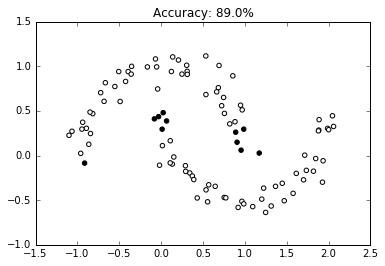

In [59]:
plt.scatter(X[:, 0], X[:, 1], c=(y != y_predicted), cmap=plt.cm.gray_r)
plt.title("Accuracy: {}%".format(100*np.mean(y == y_predicted)))